# 1. Cleaning data

### Data import

From the ``/data/Train2/files.csv`` we import all the time series recorded in the df list. Each entry of df, df[i] is a Pandas DataFrame with columns ``x, y, z, t``. 

The labels are replaced according to the three categories and stored in a list.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import interpolate
from ipywidgets import interact, IntSlider, Layout

# Creating list of Pandas Dataframes
df_list = []

# Read class data
data = pd.read_csv('../data/files.csv')

# Loop through each file in the Train2 directory and append the data to df_list
i = 0
for filename in data['folder']:
    df_list.append(pd.read_csv(os.path.join('../data/Train2',
                   filename), header=None, names=['x', 'y', 'z', 'time']))
    i = i + 1

# Replace the original class labels with new labels for classification with 3 classes
labels = data['class'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [
                               1, 1, 1, 1, 1, 2, 2, 2, 3, 3])
activities = ['moving', 'falling', 'others']

# Replace the original class labels with new labels for classification with 8 classes
# labels = data['class'].replace([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,6,6,7,8])
# activities = ['moving', 'running', 'jumping','walking_down', 'walking_up', 'falling','lying','other']


### Missing values
We verify that there are no missing values

In [2]:
# Check for missing values in each dataframe in df_list
missing_values = False
for df in df_list:
    if df.isnull().values.any():
        missing_values = True
        break

# Print a message if there are missing values
if missing_values:
    print('There are missing values in at least one dataframe')
else:
    print('There are no missing values in any dataframe')


There are no missing values in any dataframe


### Sampling time

Before moving on, we focused on the timestep. According to official documentation, the sampling frequency of the accelerometer should be the same for all registration. Many features extracted may rely and be greatly simplified by having a homogeneus timestep

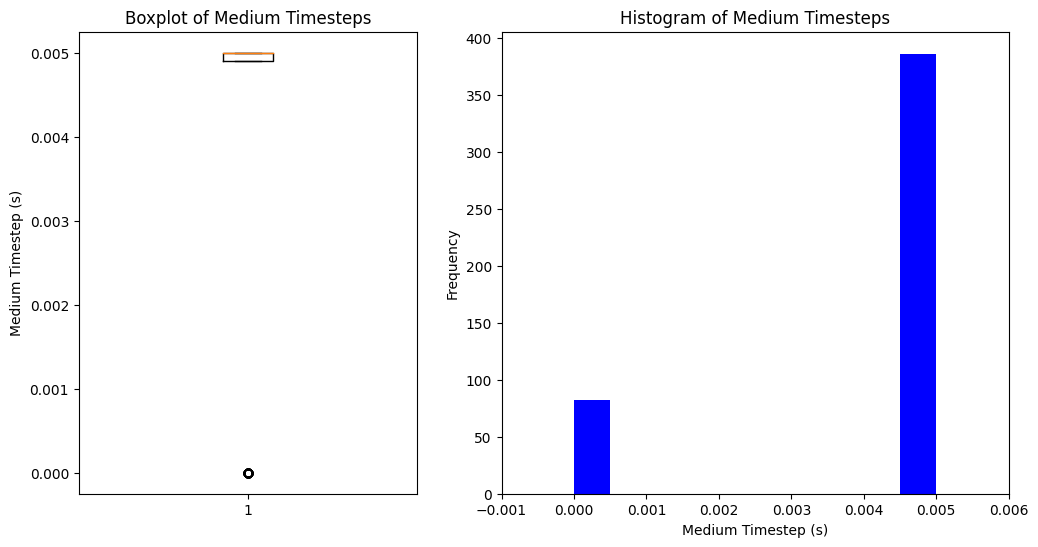

In [3]:
# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)

# Create a list to store the medium timestep for each dataframe
medium_timesteps = []

# Loop through each dataframe in df_list and calculate the medium timestep
for i, df in enumerate(df_list):
    medium_timestep = df['time'].diff().median()
    medium_timesteps.append(medium_timestep)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    12, 6), gridspec_kw={'width_ratios': [2, 3]})

# Create a boxplot of the medium timesteps
ax1.boxplot(medium_timesteps)
ax1.set_title('Boxplot of Medium Timesteps')
ax1.set_ylabel('Medium Timestep (s)')

# Create a histogram of the medium timesteps
ax2.hist(medium_timesteps, bins=10, color='blue')
ax2.set_title('Histogram of Medium Timesteps')
ax2.set_xlabel('Medium Timestep (s)')
ax2.set_ylabel('Frequency')
xticks = ax2.get_xticks()
xtick_labels = [f'{xtick:.2f}' for xtick in xticks]
ax2.set_xticks(xticks)
plt.show()


The sampling rate seems almost always coherent with what was defined on the documentation. 
There seems to be a few exceptions: in the data, time is always recorded with five digits **regardless of the number of decimal digits**.

Since starting time is not set to zeroes but varies accross observations, every observation with starting 
$\text{time} >10$ or $\text{time}>100$ will have respectively three or two digits decimal precision.

This means that some timeseries will have points recorded apparently at the same time:

In [4]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])


0    103.47
1    103.47
2    103.48
Name: time, dtype: float64


We thus process the whole dataset using pre_process_data to shift the starting time to zero and register the correct sampling rate (200Hz) to the timeseries at fault

In [5]:
def pre_process_data(data_acc, fs):
    """
    This function interpolates the accelerometer and gyroscope data to the same time interval.

    Parameters
    ----------
    data_acc : nd-array
        Accelerometer data of specified activity
    fs : int
        Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)
    """

    # Extract the time and accelerometer data from the input data
    time_acc = (data_acc.iloc[:, 3]) - data_acc.iloc[0, 3]
    data_act_acc = data_acc.iloc[:, 0:3]

    # Define the time interval for interpolation
    time_acc = np.array(time_acc)
    t0 = time_acc[0]
    tn = time_acc[-1]
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # Interpolate the accelerometer data
    data_act_acc = np.array(data_act_acc)
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(
        time_new) for ax in range(np.shape(data_act_acc)[1])]).T

    # Concatenate the interpolated data and the new time array
    data = np.column_stack((acc_data, time_new))
    data = pd.DataFrame(data, columns=['x', 'y', 'z', 'time'])

    return data


def plot_data(data):
    """This function plots the accelerometer and gyroscope data.

    Parameters
    ----------
    data nd-array
    Interpolated data

    Returns
    -------
    None

    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(data['time'], data['x'])
    axs[0, 0].set_title('X Acceleration')
    axs[0, 1].plot(data['time'], data['y'])
    axs[0, 1].set_title('Y Acceleration')
    axs[1, 0].plot(data['time'], data['z'])
    axs[1, 0].set_title('Z Acceleration')
    for ax in axs.flat:
        ax.set(xlabel='Time (s)', ylabel='Acceleration (m/s^2)')
    plt.show()


In [6]:
for i in range(len(df_list)):
    df_list[i] = pre_process_data(df_list[i], 200)


In [7]:
print(df_list[np.argmin(medium_timesteps)]['time'][0:3])


0    0.000000
1    0.005007
2    0.010013
Name: time, dtype: float64


# 2. Data visualization

Now that the data is cleaned, let's take a look at the dataset

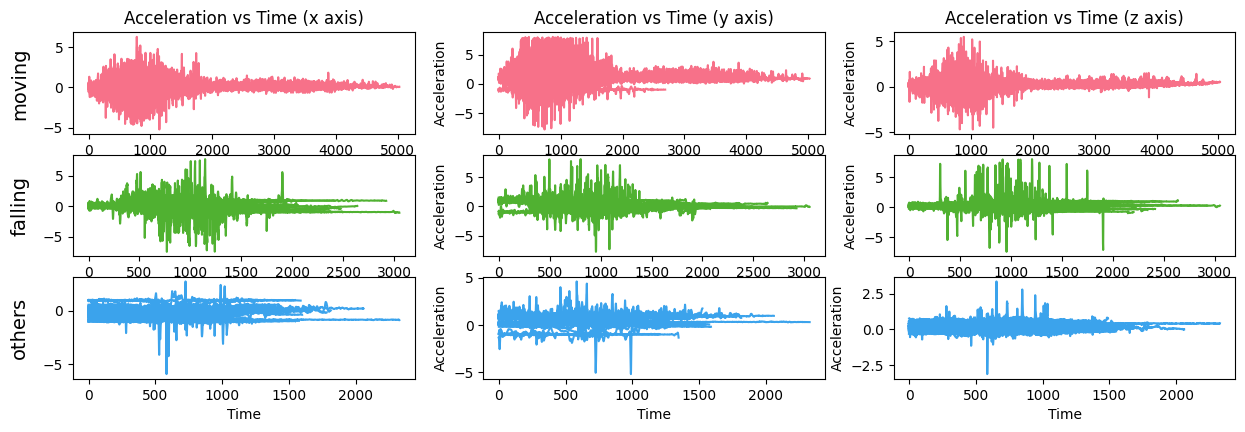

In [8]:
# Define a color palette
palette = sns.color_palette('husl', n_colors=len(activities))

# Create a color dictionary
color_dict = dict(zip(range(1, len(activities)+1), palette))
# Create a figure with three subplots
fig, axs = plt.subplots(len(activities), 3, figsize=(15, 1.5*len(activities)))

# Plot the data in each subplot
for i, df in enumerate(df_list):
    for j, col in enumerate(df.columns[:-1]):
        activity_type = labels[i]
        axs[activity_type-1][j].plot(df[col], color=color_dict[labels[i]])
        axs[activity_type-1][j].set_xlabel('Time')
        axs[activity_type-1][j].set_ylabel('Acceleration')

        axs[0][j].set_title(
            f'Acceleration vs Time ({["x", "y", "z"][j]} axis)')

    axs[activity_type-1][0].set_ylabel(
        f'{activities[activity_type-1]}', fontsize=14, rotation=90, labelpad=10)
    axs[activity_type-1][1].set_ylabel('Acceleration')
    axs[activity_type-1][2].set_ylabel('Acceleration')

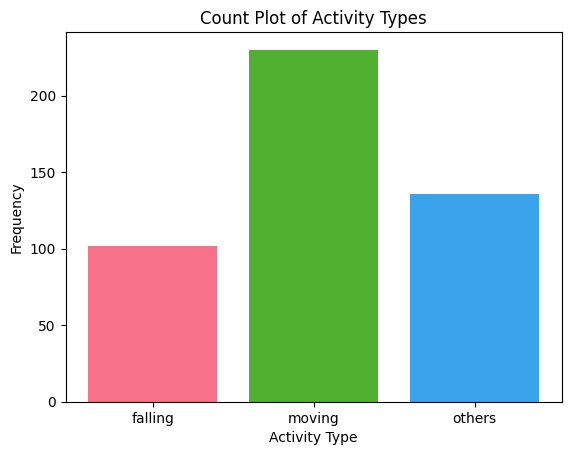

In [9]:
# Class distribution
# Calculate the unique values and their frequencies
text_labels = labels.replace(range(1, len(activities)+1), activities)
unique_values, frequencies = np.unique(text_labels, return_counts=True)

# Plotting the count plot
plt.bar(unique_values, frequencies, color=color_dict.values())
plt.xlabel('Activity Type')
plt.ylabel('Frequency')
plt.title('Count Plot of Activity Types')
plt.show()


# 3. Feature Extraction and Visualization

It's time to extract the numerical feature from our dataset to analyze it. In order to do this, we brainstormed as many relevant feature as possible to calculate that could be relevant for our problem. We identified three macro areas:

1. Basic Statistical Measures (min, max, std, ...)
2. Time Series Analysis inspired measures (turning points, zero cross count, autocorrelation, ...)
3. Signal Processing inspired measures (AUC, Peak to Peak distance, ...)

Below is the complete list, consisting of 24 features, each one extracted from each of the time series of the observation (x,y,z axis), for a total of 72 features.

The features functions and how they are calcolated are into the ``/features.py`` file. The function below calculates the feature for every observation of the df_list and append a row with the features to tsfeat.

| Statistical Measures                    | Time Series Analysis                                                                                                                                                                                                                              | Signal Processing                                       |
|-----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------|
| Max, Min, Mean,  Median, Std,  Variance | Kurtosis,  Mean Absolute Deviation, Mean (Absolute) Difference,  Median Absolute Deviation, Median (Absolute) Difference, Slope,  Sum Absolute Difference, Zero Cross Count | Area Under Curve,  Peak to Peak distance,  Total Energy, Fundamental Frequency |

In [10]:
# Import the Features class and the inspect module
from features import Features
import inspect

# Define a function to calculate features for each signal in a dataframe
def calc_features(df):
    f = Features()

    # Get a list of all the methods of the Features object
    attrs = (getattr(f, name) for name in dir(f))
    methods = filter(inspect.ismethod, attrs)

    # Create an empty dataframe to store the features
    df_features = pd.DataFrame()

    # Loop through each signal in the dataframe
    for signals in df:
        # Create empty lists to store the feature names and values
        names = []
        values = []

        # Loop through each column in the signal [x, y, z]
        for columns in signals.columns[:-1]:
            # Get the signal data as a numpy array
            signal = np.array(signals[columns])

            # Create a Features object
            f = Features()
            attrs = (getattr(f, name) for name in dir(f))
            methods = filter(inspect.ismethod, attrs)

            # Loop through each method and calculate the feature value
            for method in methods:
                # Append the feature name and value to the lists
                names.append(method.__name__ + '_' + columns)
                values.append(getattr(f, method.__name__)(signal))

        # Create a new dataframe with the feature values and names as columns
        df_new = pd.DataFrame(values, index=names).T

        # Concatenate the new dataframe with the existing dataframe
        if df_features.empty:
            df_features = df_new
        else:
            df_features = pd.concat([df_features, df_new])

    # Return the dataframe of features
    return df_features

In [11]:
tsfeat = calc_features(df_list)
tsfeat.head()

,auc_x,calc_max_x,calc_mean_x,calc_median_x,calc_min_x,calc_std_x,calc_var_x,fundamental_frequency_x,kurtosis_x,mean_abs_deviation_x,...,mean_abs_diff_z,mean_diff_z,median_abs_deviation_z,median_abs_diff_z,median_diff_z,pk_pk_distance_z,slope_z,sum_abs_diff_z,total_energy_z,zero_cross_z
0,1.557371,0.693289,0.066696,0.061151,-0.784883,0.186931,0.034943,0.088574,3.513048,0.127187,...,0.014574,-0.000002,0.072863,0.008507,-0.000759,0.592104,-0.000002,32.922238,1.857917,98.0
0,2.171963,0.470244,-0.163410,-0.127067,-1.603301,0.266975,0.071276,0.994036,3.629878,0.183407,...,0.026098,-0.000022,0.081479,0.012172,0.001242,1.692158,-0.000028,52.561213,6.522787,96.0
0,3.710821,0.177058,-0.478372,-0.434809,-1.057066,0.436291,0.190350,0.131406,-1.817942,0.416833,...,0.010757,0.000191,0.061639,0.007102,0.000148,0.624218,0.000082,16.393202,19.311767,0.0
0,4.674279,0.281936,-0.454445,-0.090394,-4.354404,0.545581,0.297658,0.104058,5.179823,0.494704,...,0.014981,-0.000204,0.177410,0.006833,-0.000236,3.948470,-0.000239,28.823818,21.526363,10.0
0,1.229189,1.308709,0.255591,0.248850,-0.325685,0.177186,0.031395,0.217391,7.632506,0.105397,...,0.016062,-0.000151,0.055582,0.008076,0.000255,1.313669,-0.000026,14.809155,7.223184,20.0


In [12]:
tsfeat.columns[0:20]


Index(['auc_x', 'calc_max_x', 'calc_mean_x', 'calc_median_x', 'calc_min_x',
       'calc_std_x', 'calc_var_x', 'fundamental_frequency_x', 'kurtosis_x',
       'mean_abs_deviation_x', 'mean_abs_diff_x', 'mean_diff_x',
       'median_abs_deviation_x', 'median_abs_diff_x', 'median_diff_x',
       'pk_pk_distance_x', 'slope_x', 'sum_abs_diff_x', 'total_energy_x',
       'zero_cross_x'],
      dtype='object')

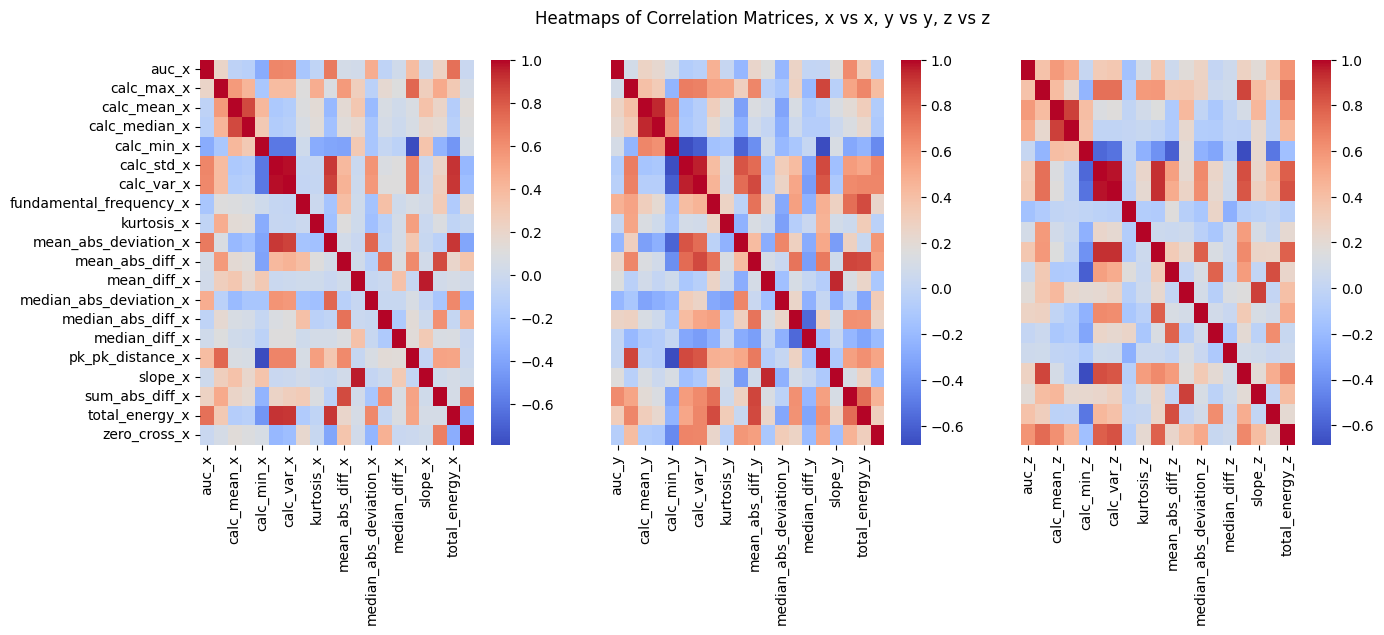

In [13]:
method_list = [func for func in dir(Features) if callable(
    getattr(Features, func)) and not func.startswith("__")]

# Calculate the correlation matrices
corr_matrix1 = tsfeat.iloc[:, :len(method_list)].corr()
corr_matrix2 = tsfeat.iloc[:, len(method_list):len(method_list)*2].corr()
corr_matrix3 = tsfeat.iloc[:, len(method_list)*2:-1].corr()

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a heatmap in each subplot
sns.heatmap(corr_matrix1, cmap='coolwarm',  ax=axes[0])
sns.heatmap(corr_matrix2, cmap='coolwarm',  ax=axes[1], yticklabels=False)
sns.heatmap(corr_matrix3, cmap='coolwarm',  ax=axes[2], yticklabels=False)

# Set the title of the plot
fig.suptitle('Heatmaps of Correlation Matrices, x vs x, y vs y, z vs z')

# Show the plot
plt.show()


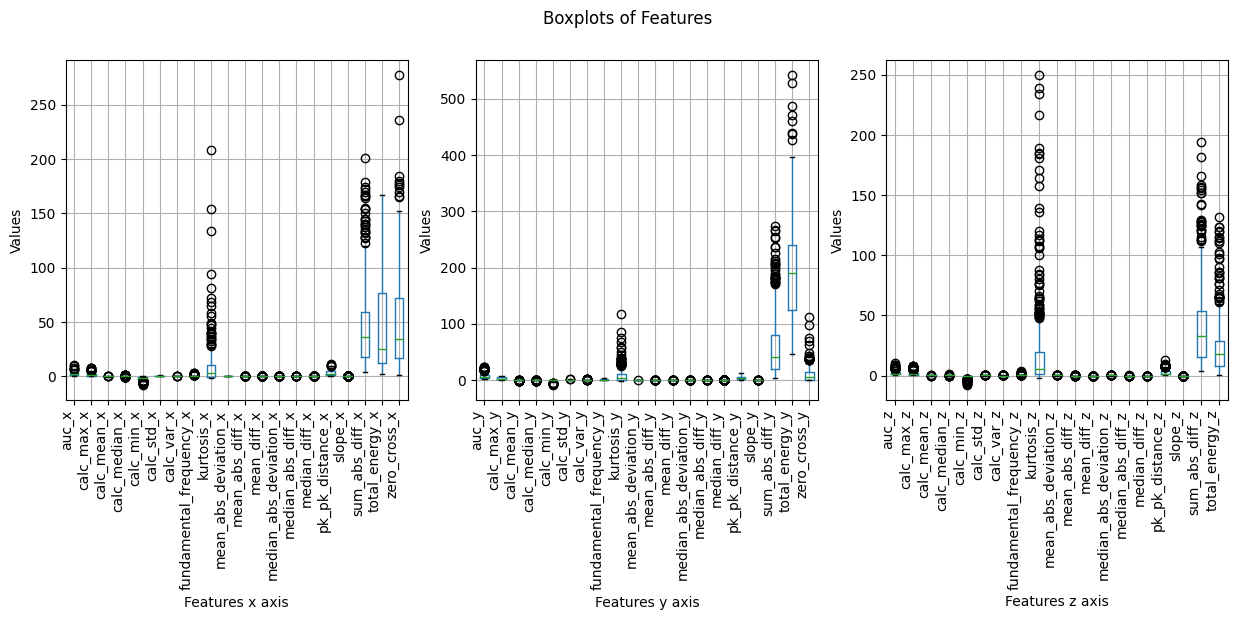

In [14]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create a boxplot in each subplot
tsfeat.iloc[:, :len(method_list)].boxplot(ax=axes[0])
tsfeat.iloc[:, len(method_list):len(method_list)*2].boxplot(ax=axes[1])
tsfeat.iloc[:, len(method_list)*2:-1].boxplot(ax=axes[2])

# Set the labels and title of the plot
fig.suptitle('Boxplots of Features')
axes[0].set_xlabel('Features x axis')
axes[0].set_ylabel('Values')
axes[1].set_xlabel('Features y axis')
axes[1].set_ylabel('Values')
axes[2].set_xlabel('Features z axis')
axes[2].set_ylabel('Values')
fig.autofmt_xdate(rotation=90)

# Show the plot
plt.show()


## Interactive visualization of boxplots feature vs classes, divided by axis

In [15]:
# Define a function to create a boxplot for a given feature
def create_boxplot(feature):
    # Group the data by class label
    grouped_data = tsfeat.copy()
    grouped_data['activity'] = list(labels.replace(range(1,len(activities)+1),activities))

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Create a boxplot in each subplot
    grouped_data.iloc[:, :].boxplot(ax=axes[0], column = tsfeat.columns[feature], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[1], column = tsfeat.columns[feature+len(method_list)], by='activity')
    grouped_data.iloc[:, :].boxplot(ax=axes[2], column = tsfeat.columns[feature+len(method_list)*2], by='activity')

    # Set the labels and title of the plot
    fig.suptitle('Boxplots of Features {}'.format(tsfeat.columns[feature][:-2]))
    fig.autofmt_xdate(rotation=90)

# Create a slider to change features
slider_layout = Layout(width='50%')
feature_slider = IntSlider(min=0, max=tsfeat.shape[1]/3 -1, step=1, value=0, layout=slider_layout, description='Select Feature:', style={'description_width': 'initial', 'handle_color': 'blue'})


# Create an interactive plot
interact(create_boxplot, feature=feature_slider)

interactive(children=(IntSlider(value=0, description='Select Feature:', layout=Layout(width='50%'), max=19, st…

<function __main__.create_boxplot(feature)>

# 4. Model making


We now establish a pipeline for our data.

Before exploring and developing the models:
- 4.1.1 Feature selection via correlation (removal of highly correlated features)
- 4.1.2 Split dataset into train and test, normalize data (according to the boxplots seen above features have highly different order of magnitudes - and we will be using distance based classification methods)
- 4.1.3 Define useful plotting function for model evaluation (confusion matrix, accuracy, importance)

We will look then one by one at the following classification models:
- Logistic Regression
- Random Forest
- KNN
- SVM
- Naive Bayes Classifier

For each of them:
- General fit of the model
- Tune parameters according to gridSearchCV
- Evaluate performance using Confusion Matrix and Accuracy

If the performance is good:
- Look at the importances of the features
- Perform feature selection using importance (criteria: elbow criteria for false positive rate of Falling class)
- Evaluate performance on model selected with k most important features (Confusion Matrix, ROC, Partial Dependence Plots)


## 4.1 Getting the dataset ready for the models
### 4.1.1 Feature selection via correlation

We start by importing all the function used later for fitting and evaluating models

In [16]:
# Import the necessary modules for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import the necessary modules for cross validation and traing/test split
from sklearn.model_selection import train_test_split, cross_val_score

# Import the necessary modules for permutation importance
from sklearn.inspection import permutation_importance

# Import the necessary modules for standardization
from sklearn.preprocessing import StandardScaler

# Import the necessary modules for logistic regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Import the necessary modules for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree

# Import the necessary modules for KNN
from sklearn.neighbors import KNeighborsClassifier

# Import the necessary modules for SVC
from sklearn.svm import SVC

# Import the necessary modules for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Import the necessary modules for ensemble model
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier

# Import the necessary modules for TSNE and interactive plots
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact


We compute the correlation matrix and keep non-highly correlated features (|corr| <= 0.7)

In [17]:
# Compute the correlation matrix
corr_matrix = tsfeat.corr()

# Select the highly correlated features
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            if colname_i not in highly_correlated_features and colname_j not in highly_correlated_features:
                highly_correlated_features.add(colname_i)

# Remove the highly correlated features from the dataset
tsfeat_no_corr = tsfeat.drop(highly_correlated_features, axis=1)

# Print the remaining features
print('Remaining Features:', tsfeat_no_corr.columns)


Remaining Features: Index(['auc_x', 'calc_max_x', 'calc_mean_x', 'calc_min_x', 'calc_std_x',
       'fundamental_frequency_x', 'kurtosis_x', 'mean_abs_diff_x',
       'mean_diff_x', 'median_abs_deviation_x', 'median_diff_x',
       'zero_cross_x', 'calc_max_y', 'calc_mean_y', 'calc_min_y',
       'fundamental_frequency_y', 'kurtosis_y', 'mean_abs_deviation_y',
       'mean_diff_y', 'median_abs_deviation_y', 'median_abs_diff_y',
       'median_diff_y', 'zero_cross_y', 'auc_z', 'calc_max_z', 'calc_mean_z',
       'calc_min_z', 'fundamental_frequency_z', 'kurtosis_z',
       'mean_abs_deviation_z', 'mean_diff_z', 'median_diff_z', 'zero_cross_z'],
      dtype='object')


### 4.1.2 Dataset Split and Normalization

Dataset is split in train-test 

In [18]:
# Division in Train and Test set (70%-30%)
X_train, X_test, Y_train, Y_test = train_test_split(tsfeat_no_corr, np.array(
    list(labels)), test_size=0.3, random_state=1999, stratify=np.array(list(labels)))


In [19]:
X_train.head()


,auc_x,calc_max_x,calc_mean_x,calc_min_x,calc_std_x,fundamental_frequency_x,kurtosis_x,mean_abs_diff_x,mean_diff_x,median_abs_deviation_x,...,auc_z,calc_max_z,calc_mean_z,calc_min_z,fundamental_frequency_z,kurtosis_z,mean_abs_deviation_z,mean_diff_z,median_diff_z,zero_cross_z
0,3.060291,1.248543,0.240590,-0.467079,0.536058,0.151745,-1.602982,0.011057,0.000887,0.109990,...,0.960108,0.418069,0.092382,-0.645665,0.151745,-0.099338,0.140185,0.000343,0.000132,19.0
0,1.669204,0.689544,-0.065382,-0.974116,0.244243,1.102536,1.152088,0.030722,-0.000013,0.109034,...,3.950720,1.628006,0.435323,-0.029520,0.330761,6.329716,0.119535,-0.000021,0.001344,2.0
0,1.229890,0.569174,-0.142659,-0.624948,0.330483,0.236967,-1.407496,0.011083,-0.000647,0.251778,...,0.712271,0.420252,0.117929,-0.287955,0.236967,0.251495,0.114466,-0.000018,0.000530,4.0
0,1.007608,0.628524,0.178558,-0.077322,0.096284,0.359712,2.144771,0.011252,-0.000029,0.032628,...,0.646881,0.344874,0.105378,-0.137998,0.179856,-0.443577,0.070759,0.000011,0.000047,32.0
0,0.987784,0.293513,-0.111494,-0.473247,0.207450,0.173310,-1.149697,0.008965,-0.000119,0.110024,...,2.321867,0.719953,0.402027,0.150400,0.173310,-0.601676,0.096355,0.000260,0.000409,0.0


In [20]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(327, 33)
(141, 33)
(327,)
(141,)


Normalize training data and use the scaling parameters for the test set

In [21]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 4.1.3 Defining functions for plotting metrics

In [22]:
# Function to plot the future importances and the confusion matrix
def plot_importance_confusion(importances, X_train, y_predict, activities):
    # Plot the feature importances and confusion matrix side by side
    fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

    # Plot the feature importances
    axs[0].bar(X_train.columns, importances)
    values_list = np.arange(0, len(X_train.columns))
    axs[0].xaxis.set_ticks(values_list)
    axs[0].set_xticklabels(X_train.columns, rotation=90)
    axs[0].set_title('Feature Importances')

    # Plot the confusion matrix
    cm = confusion_matrix(Y_test, y_predict, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xticklabels(activities, rotation=90)
    axs[1].set_yticklabels(activities, rotation=90)

    plt.show()


In [23]:
# Function to plot the future importances and the confusion matrix for top k features
def plot_importance_confusion_top_k(importances, X_train, y_predict, activities, top_k_features, top_k_indices, k):
    # Plot the feature importances and confusion matrix side by side
    fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

    # Plot the feature importances
    axs[0].bar(top_k_features, importances[top_k_indices])
    values_list = np.arange(0, k)
    axs[0].xaxis.set_ticks(values_list)
    axs[0].set_xticklabels(top_k_features, rotation=90)
    axs[0].set_xlabel('Features')
    axs[0].set_ylabel('Importance')
    axs[0].set_title('Feature Importances')

    # Plot the confusion matrix
    cm = confusion_matrix(Y_test, y_predict, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xticklabels(activities, rotation=90)
    axs[1].set_yticklabels(activities, rotation=90)

    plt.show()


In [24]:
# Get the classification report and evaluate the model using cross-validation on the training set
def evaluate_model(model, X_train_scaled, y_predict, Y_train, Y_test, activities):
    accuracy = accuracy_score(Y_test, y_predict)*100
    print(classification_report(Y_test, y_predict, target_names=activities))
    print('Accuracy: ' + str(accuracy) + '%')

    scores = cross_val_score(model, X_train_scaled, Y_train, cv=5)
    print('Cross-validation scores:', scores)
    print('Mean cross-validation score:', scores.mean())


In [25]:
# Get the classification report and evaluate the model using cross-validation on the training set for top k features
def evaluate_model_top_k(model, X_train_scaled, y_predict, Y_train, Y_test, activities, top_k_indices):
    accuracy = accuracy_score(Y_test, y_predict)*100
    print(classification_report(Y_test, y_predict, target_names=activities))
    print('Accuracy: ' + str(accuracy) + '%')

    scores = cross_val_score(
        model, X_train_scaled[:, top_k_indices], Y_train, cv=5)
    print('Cross-validation scores:', scores)
    print('Mean cross-validation score:', scores.mean())


## 4.2 Model development

### 4.2.1 Logistic Regression

We start with **LOGISTIC REGRESSION**
The first model is a general fit on all the training set using GridSearch to find the best hyperparameters (regularization weights).

In [26]:
# Perform hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Train the logistic regression classifier with the best hyperparameters
logistic_regression_classifier = grid_search.best_estimator_
logistic_regression_classifier.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = logistic_regression_classifier.predict(X_test_scaled) 

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(logistic_regression_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)

# Calculate the odds ratio and effect size
odds_ratio = np.exp(logistic_regression_classifier.coef_)
effect_size = odds_ratio / (odds_ratio + 1)

# Get the effect sizes
effect_sizes = logistic_regression_classifier.coef_[0]


              precision    recall  f1-score   support

      moving       0.99      1.00      0.99        69
     falling       0.94      0.94      0.94        31
      others       0.97      0.95      0.96        41

    accuracy                           0.97       141
   macro avg       0.97      0.96      0.96       141
weighted avg       0.97      0.97      0.97       141

Accuracy: 97.16312056737588%
Cross-validation scores: [0.98484848 0.98484848 0.98461538 0.95384615 0.96923077]
Mean cross-validation score: 0.9754778554778556


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

The results look promising. In fact, the ConvergenceWarning with optimal results signify an almost perfect separation of the classes.

For a unit change in the predictor variable, the logit of outcome m relative to the referent group is expected to change by its respective parameter estimate given the variables in the model are held constant. 
Let's take a look at the coefficients for interpretability:

$\text{logit}({p_i})= \log(\text{Odds Ratio}) = \log{\frac{\exp{X_i \beta}}{\sum_{j}{X_j \beta}}}$

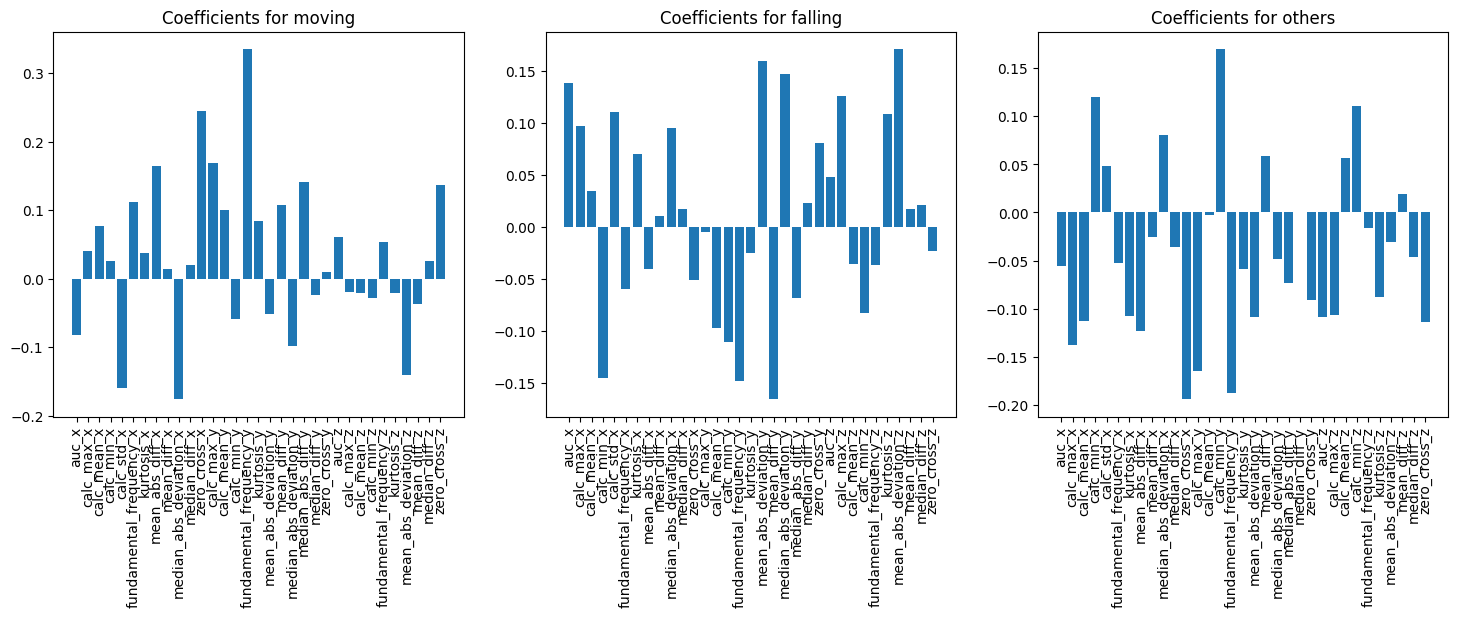

In [27]:
# Get the coefficients for each class
coefficients = logistic_regression_classifier.coef_

# Plot the coefficients for each class
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i in range(len(activities)):
    axs[i].bar(range(len(coefficients[i])), coefficients[i])
    axs[i].set_xticks(range(len(effect_sizes)))
    axs[i].set_xticklabels(X_train.columns, rotation=90)
    axs[i].set_title('Coefficients for ' + activities[i])
plt.show()


#### Feature importance selection

Using the feature importances (the effects of the feature on the prediction) we select the most important features and refit the model.


In [28]:
# Use feature selection to select the most important features
feature_selector = SelectFromModel(
    logistic_regression_classifier, threshold=-np.inf, max_features=13)
feature_selector.fit(X_train_scaled, Y_train)

# Get the selected features
selected_features = X_train.columns[feature_selector.get_support()]
index_selected_features = feature_selector.get_support(indices=True)

# Train the logistic regression model with the selected features
X_train_selected = X_train_scaled[:, index_selected_features]
X_test_selected = X_test_scaled[:, index_selected_features]

logistic_regression_classifier.fit(X_train_selected, Y_train)

# Predict test data with the selected features
y_predict_selected = logistic_regression_classifier.predict(X_test_selected)

# Get the classification report and confusion matrix
accuracy_selected = accuracy_score(Y_test, y_predict_selected)*100
print(classification_report(Y_test, y_predict_selected, target_names=activities))
print('Accuracy with selected features: ' + str(accuracy_selected) + '%')
conf_matrix_selected = confusion_matrix(Y_test, y_predict_selected)


              precision    recall  f1-score   support

      moving       0.99      1.00      0.99        69
     falling       0.88      0.94      0.91        31
      others       0.97      0.90      0.94        41

    accuracy                           0.96       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141

Accuracy with selected features: 95.74468085106383%


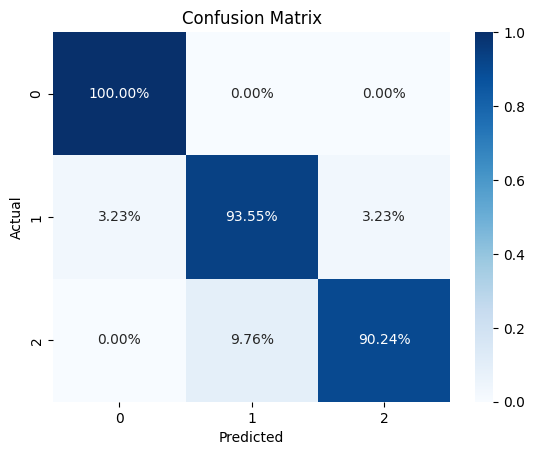

In [29]:
# Plot the confusion matrix
cm = confusion_matrix(Y_test, y_predict_selected, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


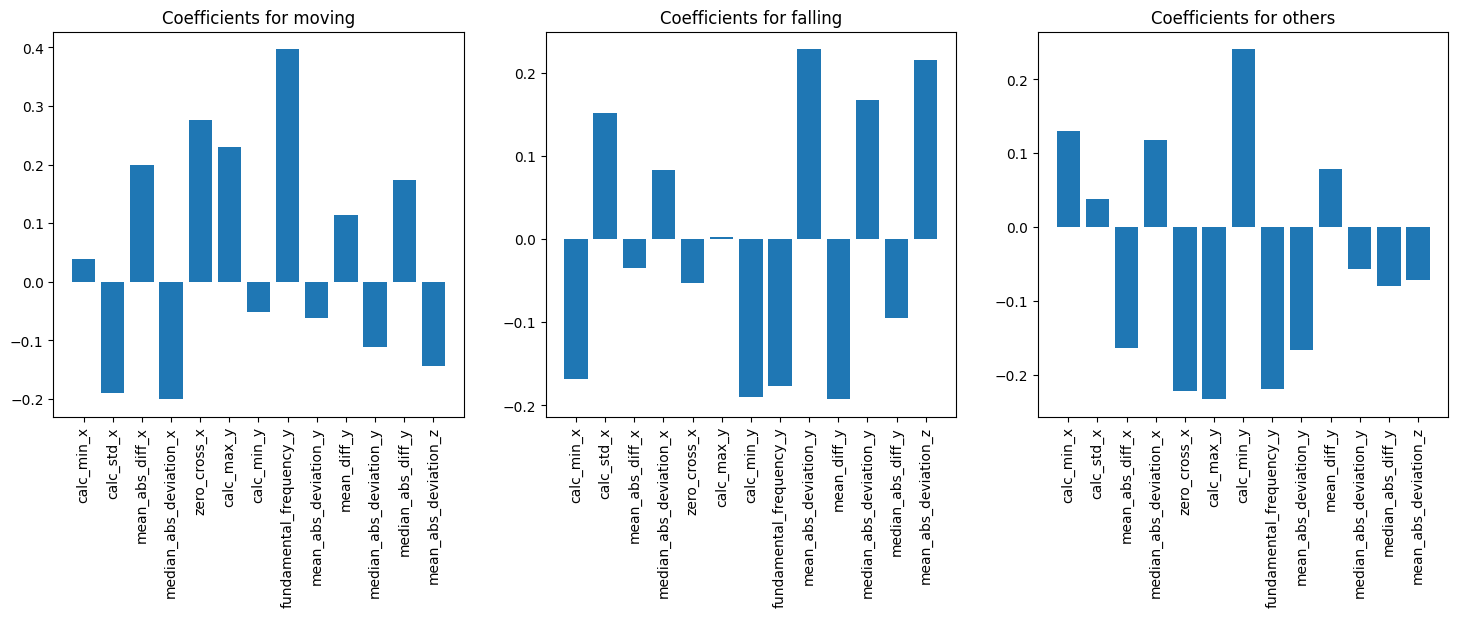

In [31]:
# Get the coefficients for each class
coefficients = logistic_regression_classifier.coef_

# Plot the coefficients for each class
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i in range(len(activities)):
    axs[i].bar(range(len(coefficients[i])), coefficients[i])
    axs[i].set_xticks(range(selected_features.shape[0]))
    axs[i].set_xticklabels(selected_features, rotation=90)
    axs[i].set_title('Coefficients for ' + activities[i])
plt.show()



#### ROC

Let's plot the ROC relative to the **falling** class (positive class)

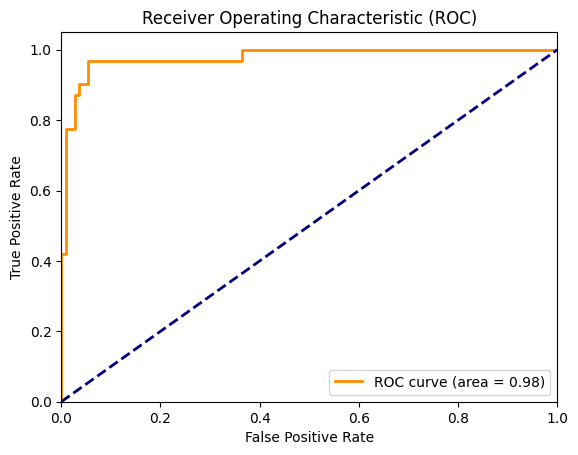

In [32]:
# Compute the predicted probabilities for the positive class (class 2 = Falling)
y_prob = logistic_regression_classifier.predict_proba(X_test_selected)[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(Y_test, y_prob, pos_label=2)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 4.2.2 Random Forest

The second model is a **RANDOM FOREST**.

We start with a general fit on all the training set using GridSearch to find the best hyperparameters.

#### GridSearch

In [33]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train the random forest classifier using cross-validation and hyperparameter tuning
random_forest_classifier = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the random forest classifier using the best hyperparameters
random_forest_classifier = RandomForestClassifier(**best_params)
random_forest_classifier.fit(X_train_scaled, Y_train)

# Get the feature importances
importances = random_forest_classifier.feature_importances_

# Predict test data
y_predict = random_forest_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(random_forest_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


              precision    recall  f1-score   support

      moving       0.99      1.00      0.99        69
     falling       0.91      0.97      0.94        31
      others       1.00      0.93      0.96        41

    accuracy                           0.97       141
   macro avg       0.96      0.96      0.96       141
weighted avg       0.97      0.97      0.97       141

Accuracy: 97.16312056737588%
Cross-validation scores: [0.98484848 0.98484848 0.95384615 0.96923077 0.96923077]
Mean cross-validation score: 0.9724009324009325


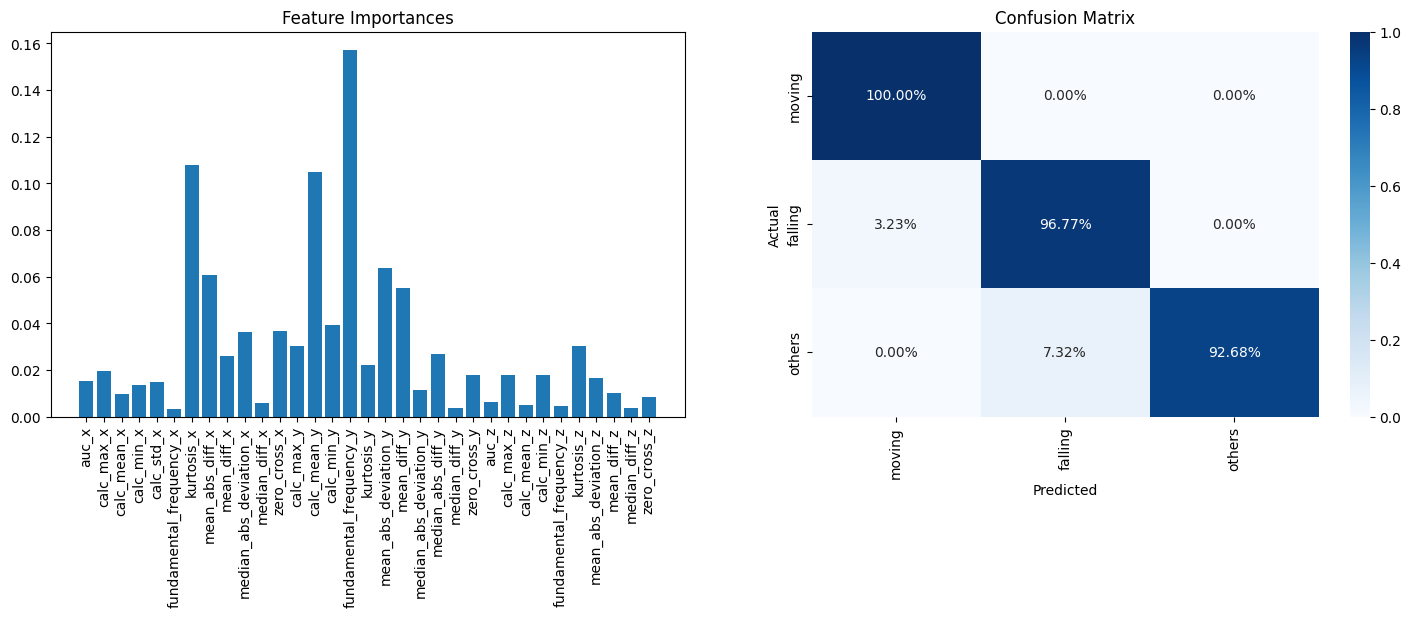

In [34]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)

#### Feature importance selection

Using the feature importances (the effects of the feature on the prediction) we select the most important features and refit the model.


In [35]:
# Select the top k features
k = 4
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the random forest classifier using the top k features
random_forest_classifier = RandomForestClassifier(**best_params)
random_forest_classifier.fit(X_train_scaled[:, top_k_indices], Y_train)

# Predict test data
y_predict = random_forest_classifier.predict(X_test_scaled[:, top_k_indices])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(random_forest_classifier, X_train_scaled,
                     y_predict, Y_train, Y_test, activities, top_k_indices)


              precision    recall  f1-score   support

      moving       1.00      1.00      1.00        69
     falling       0.88      0.97      0.92        31
      others       0.97      0.90      0.94        41

    accuracy                           0.96       141
   macro avg       0.95      0.96      0.95       141
weighted avg       0.97      0.96      0.96       141

Accuracy: 96.45390070921985%
Cross-validation scores: [0.96969697 0.98484848 0.93846154 0.95384615 0.95384615]
Mean cross-validation score: 0.9601398601398602


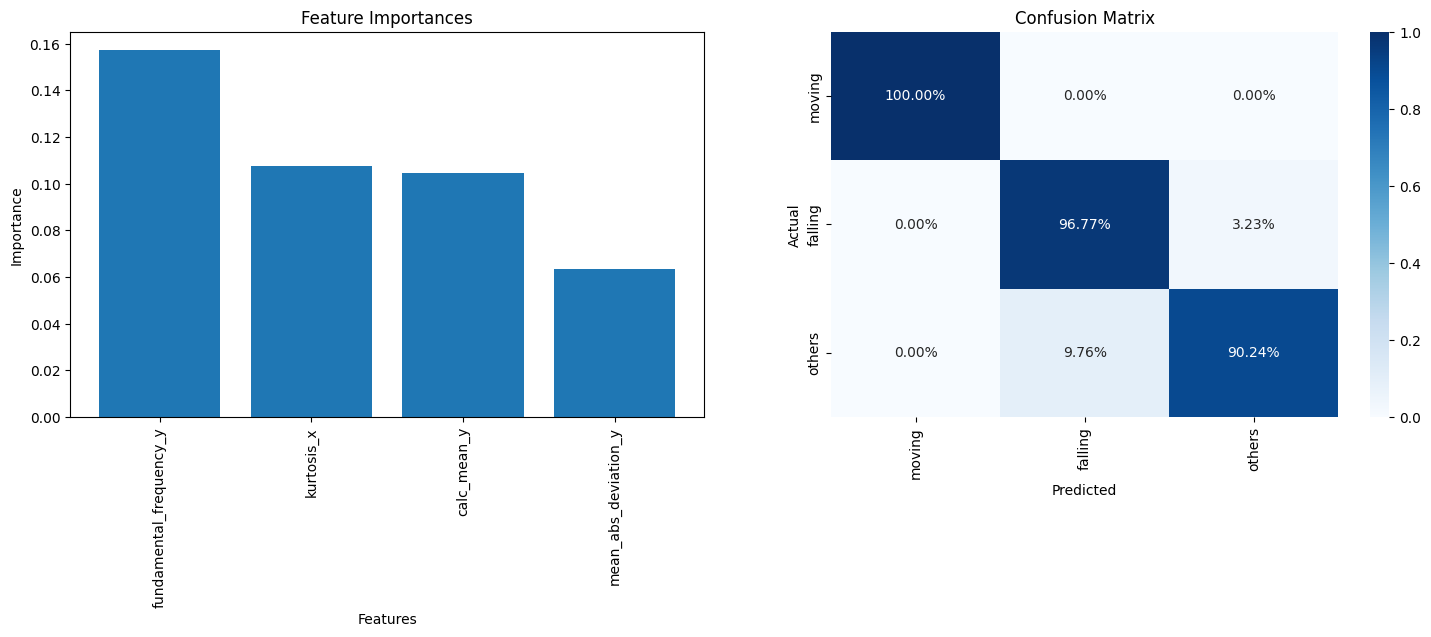

In [36]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


#### Partial Dependence Plots

The results seem exceptional at separating classes. We use now partial dependence plot using most important feature **fundamental_frequency_y** vs the other three to interpret the effect.

The target here is the **FALLING** class

Text(0, 0.5, 'Partial Dependence')

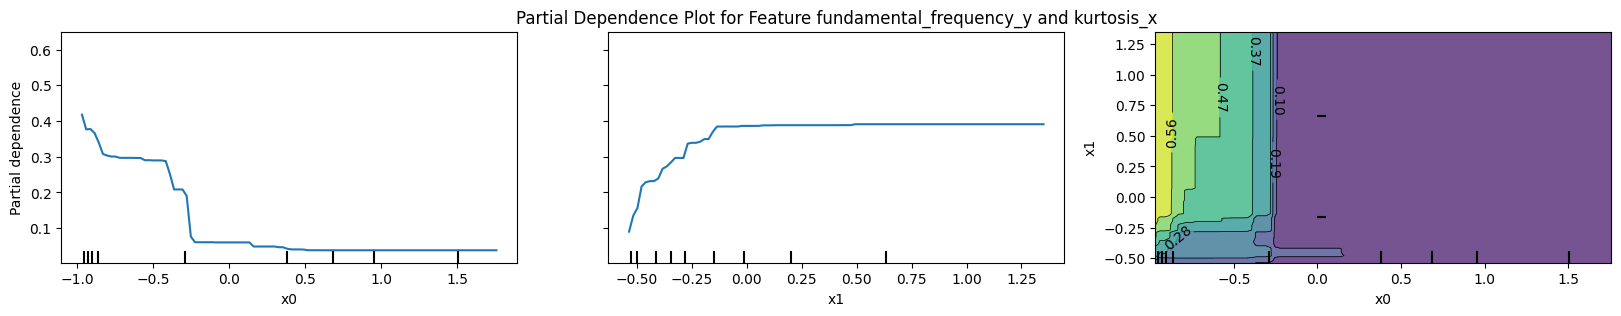

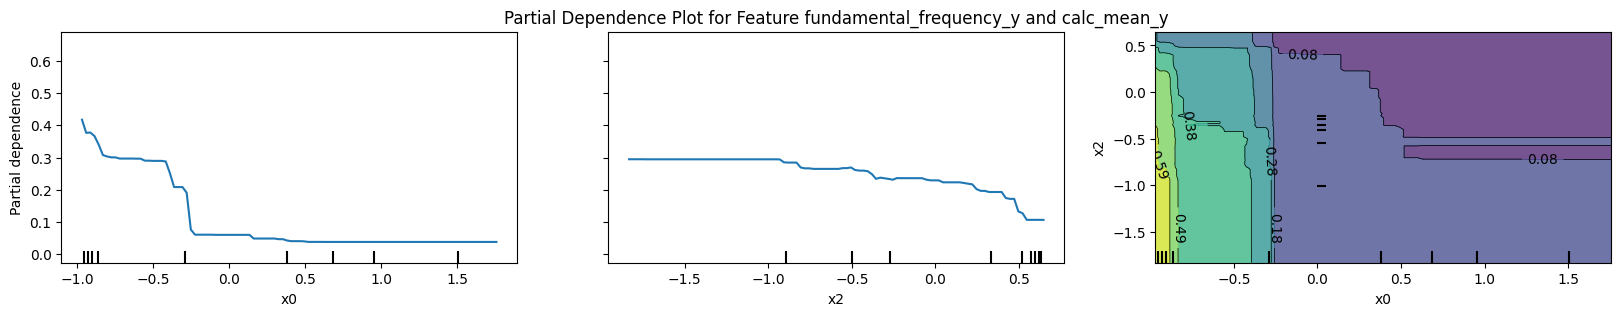

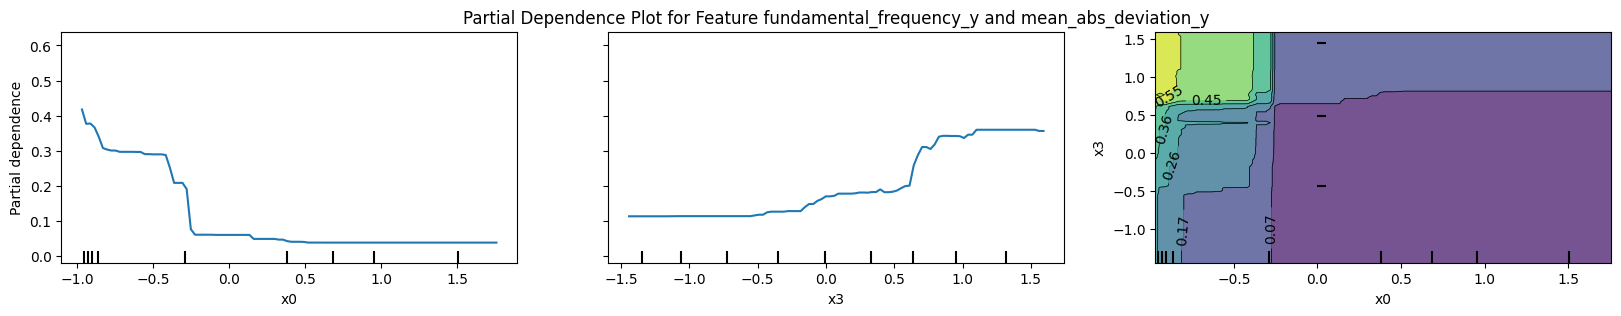

In [37]:
# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 3))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 1, (0,1)], ax=ax, target=2)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[1]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 3))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 2, (0,2)], ax=ax, target=2)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[2]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 3))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 3, (0,3)], ax=ax, target=2)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[3]))
ax.set_ylabel('Partial Dependence')

The target here is the **MOVING** class

Text(0, 0.5, 'Partial Dependence')

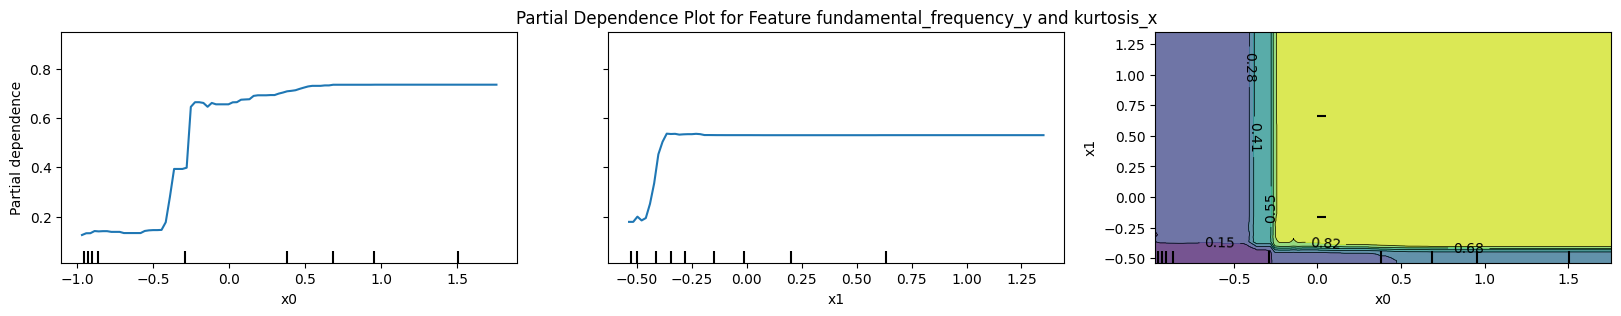

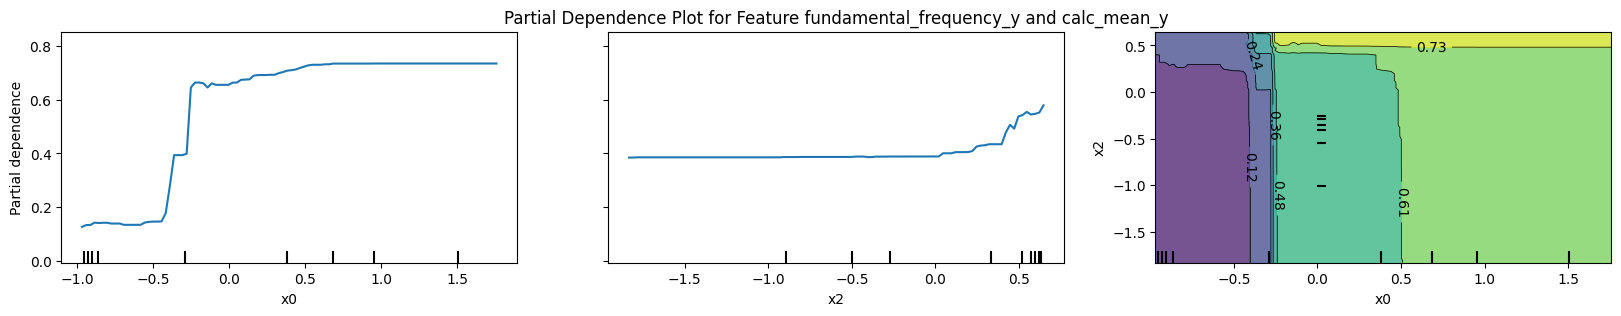

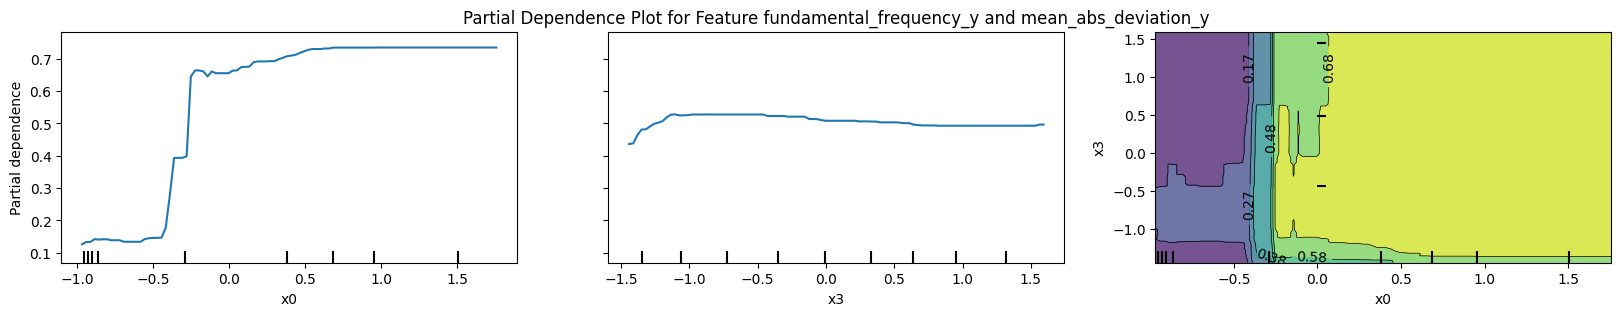

In [38]:
# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 3))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 1, (0,1)], ax=ax, target=1)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[1]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 3))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 2, (0,2)], ax=ax, target=1)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[2]))
ax.set_ylabel('Partial Dependence')

# Create the partial dependence plot for the top feature
fig, ax = plt.subplots(figsize=(20, 3))
PartialDependenceDisplay.from_estimator(random_forest_classifier, X_train_scaled[:, top_k_indices], [0, 3, (0,3)], ax=ax, target=1)
ax.set_title('Partial Dependence Plot for Feature {} and {}'.format(top_k_features[0], top_k_features[3]))
ax.set_ylabel('Partial Dependence')

#### Tree visualization

Let's visualize a tree in the random forest

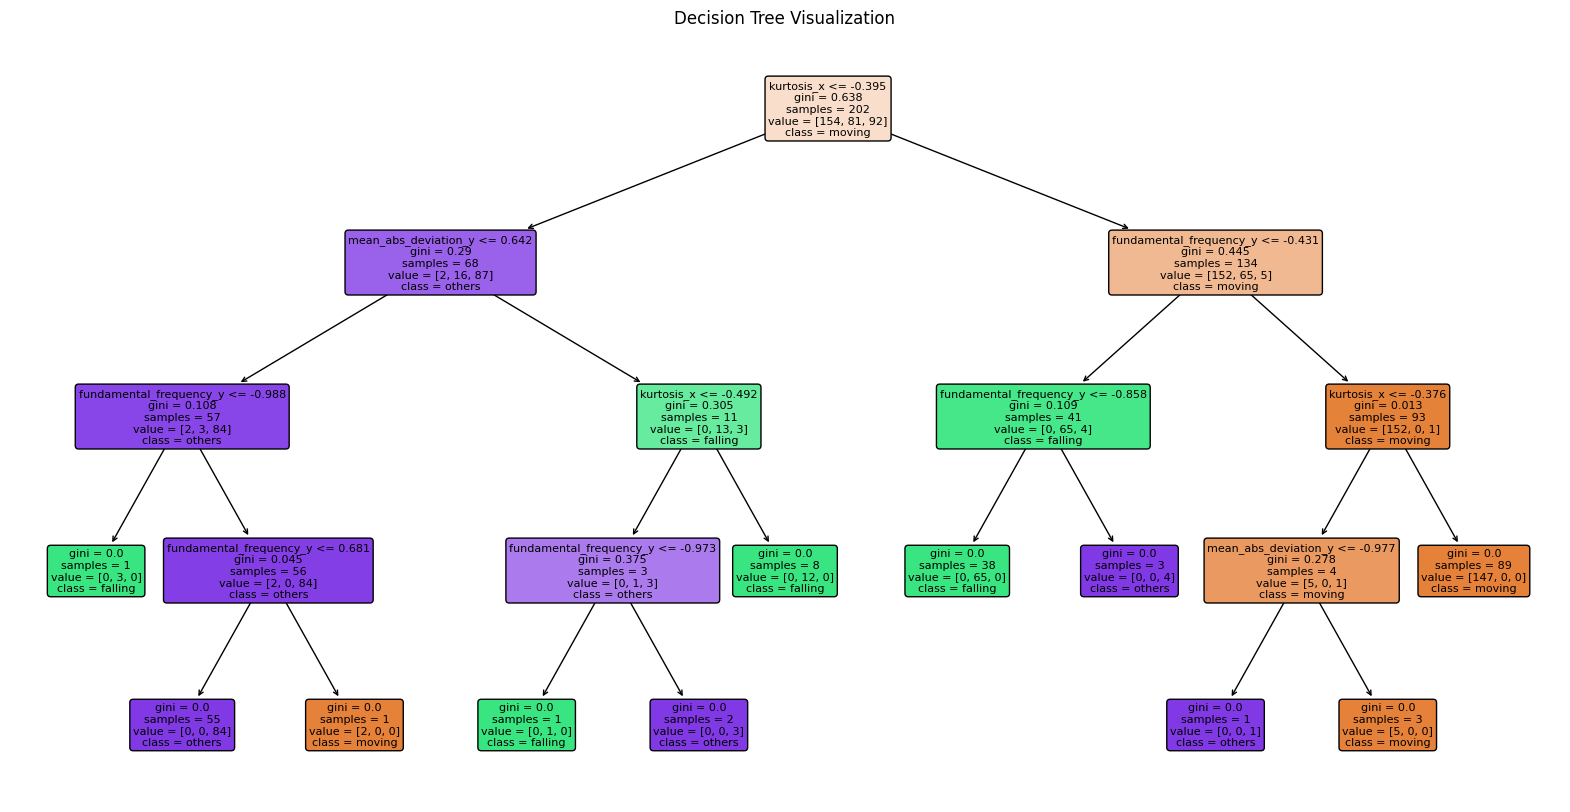

In [45]:
# Create the tree visualization for the first tree in the forest
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(random_forest_classifier.estimators_[5], ax=ax, feature_names=top_k_features, class_names=activities, filled=True, rounded=True, fontsize=8)
ax.set_title('Decision Tree Visualization')
plt.show()

#### ROC

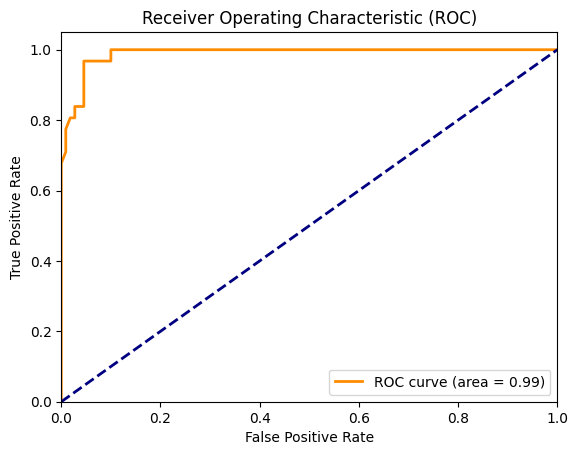

In [42]:
# Compute the predicted probabilities for the positive class
y_prob = random_forest_classifier.predict_proba(X_test_scaled[:,top_k_indices])[:, 1]

# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(Y_test, y_prob, pos_label=2)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

This is the most promising model. Let's plot a scatter plot of two of the most important features to see how they separate the dataset

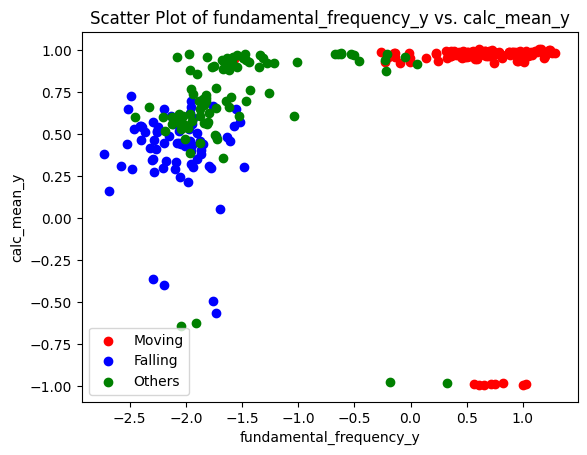

In [39]:
# Define the x and y variables
x = np.log(X_train['fundamental_frequency_y'])
y = X_train['calc_mean_y']

# Define the colors for each label
named_labels = pd.Series(Y_train).replace(
    {1: 'Moving', 2: 'Falling', 3: 'Others'})
colors = {'Moving': 'red', 'Falling': 'blue', 'Others': 'green'}

# Create the scatter plot
fig, ax = plt.subplots()
for label in colors:
    mask = named_labels == label
    ax.scatter(x[list(mask)], y[list(mask)], c=colors[label], label=label)

# Set the axis labels and title
ax.set_xlabel('fundamental_frequency_y')
ax.set_ylabel('calc_mean_y')
ax.set_title('Scatter Plot of fundamental_frequency_y vs. calc_mean_y')

# Add the legend
ax.legend()

# Show the plot
plt.show()


### 4.2.3 KNN

The third model uses **KNN**.

We start with a general fit on all the training set using GridSearch to find the best hyperparameters.

In [50]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the number of neighbors
param_grid = {'n_neighbors': range(1, 11)}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_scaled, Y_train)

# Get the best number of neighbors from the grid search object
best_n_neighbors = grid_search.best_params_['n_neighbors']

# Create a new KNN classifier with the best number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors)

# Fit the KNN classifier
knn_classifier.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = knn_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(knn_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)

              precision    recall  f1-score   support

      moving       0.95      1.00      0.97        69
     falling       0.89      0.81      0.85        31
      others       0.90      0.88      0.89        41

    accuracy                           0.92       141
   macro avg       0.91      0.89      0.90       141
weighted avg       0.92      0.92      0.92       141

Accuracy: 92.19858156028369%
Cross-validation scores: [0.98484848 0.98484848 0.98461538 0.93846154 1.        ]
Mean cross-validation score: 0.9785547785547786


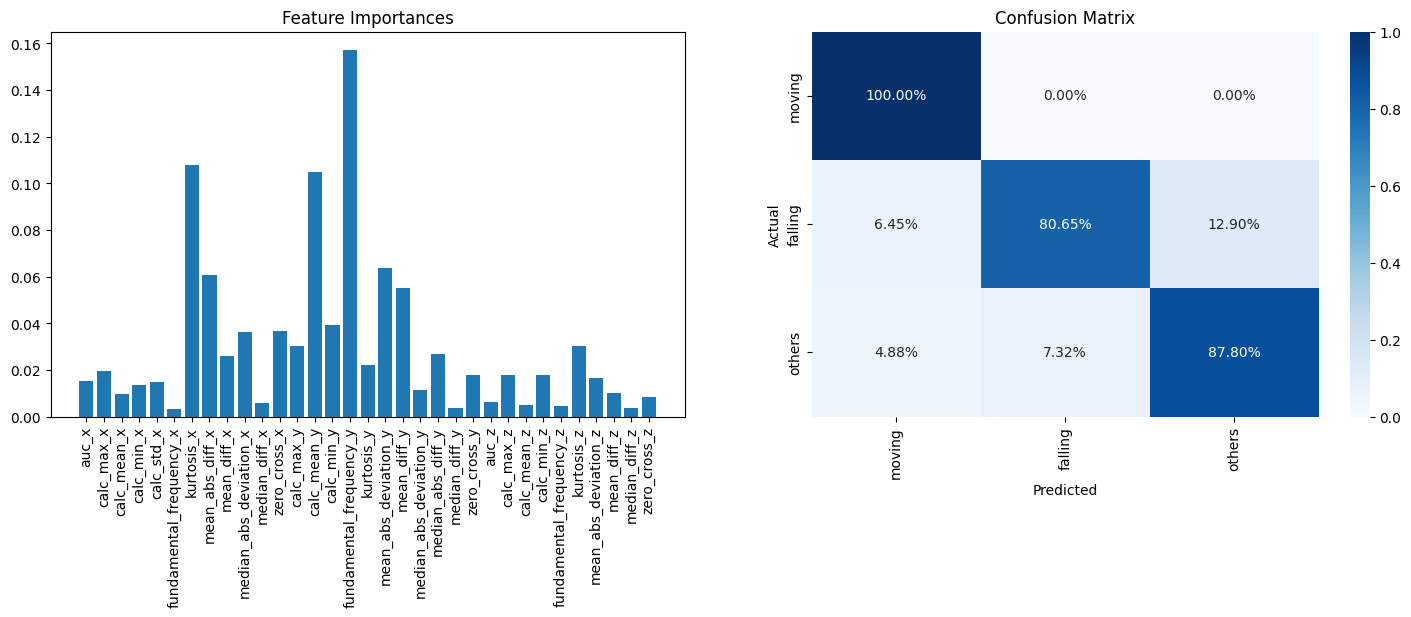

In [51]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

Using the feature importances we select the most important features and refit the model.

In [52]:
# Select the top k features
k = 4
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the KNN classifier using the top k features
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled[:, top_k_indices], Y_train)

# Predict test data
y_predict = knn_classifier.predict(X_test_scaled[:, top_k_indices])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(knn_classifier, X_train_scaled, y_predict,
                     Y_train, Y_test, activities, top_k_indices)


              precision    recall  f1-score   support

      moving       0.96      1.00      0.98        69
     falling       0.88      0.94      0.91        31
      others       0.97      0.85      0.91        41

    accuracy                           0.94       141
   macro avg       0.94      0.93      0.93       141
weighted avg       0.94      0.94      0.94       141

Accuracy: 94.32624113475178%
Cross-validation scores: [0.95454545 0.93939394 0.92307692 0.92307692 0.96923077]
Mean cross-validation score: 0.9418648018648019


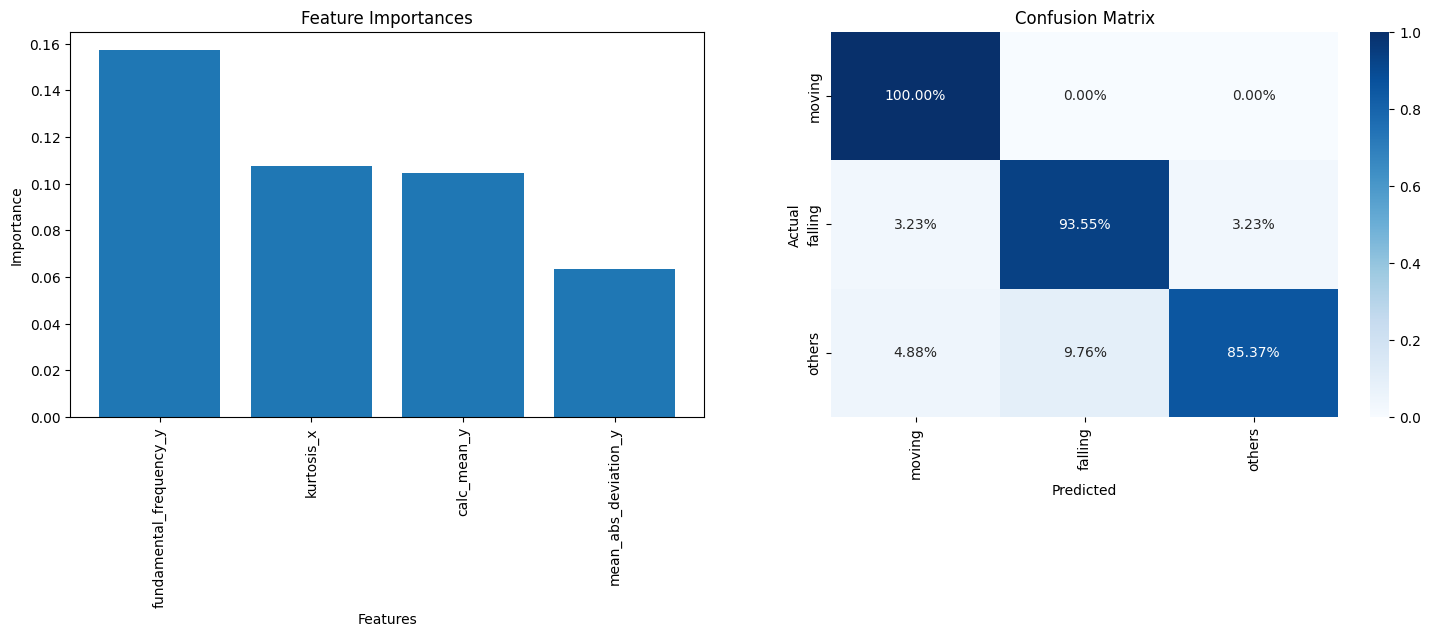

In [53]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


### 4.2.4 SVM

The fourth model uses **SVM**.

We start with a general fit on all the training set using GridSearch to find the best hyperparameters.

In [54]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Train the SVC using GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)

# Get the best hyperparameters and kernel
best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']
best_gamma = best_params['gamma']

# Train the SVC with the best hyperparameters and kernel
svm_classifier = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, probability=True)
svm_classifier.fit(X_train_scaled, Y_train)

# Get the feature importances using permutation importance

# Permutation importance measures the importance of a feature by randomly permuting its values
# and observing the impact on the model's performance. If permuting a feature greatly reduces the
# model's performance, it suggests that the feature is important.

result = permutation_importance(
    svm_classifier, X_test_scaled, Y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Predict test data
y_predict = svm_classifier.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(svm_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


              precision    recall  f1-score   support

      moving       0.97      1.00      0.99        69
     falling       0.94      0.94      0.94        31
      others       0.97      0.93      0.95        41

    accuracy                           0.96       141
   macro avg       0.96      0.95      0.96       141
weighted avg       0.96      0.96      0.96       141

Accuracy: 96.45390070921985%
Cross-validation scores: [0.98484848 0.98484848 0.98461538 0.93846154 0.98461538]
Mean cross-validation score: 0.9754778554778556


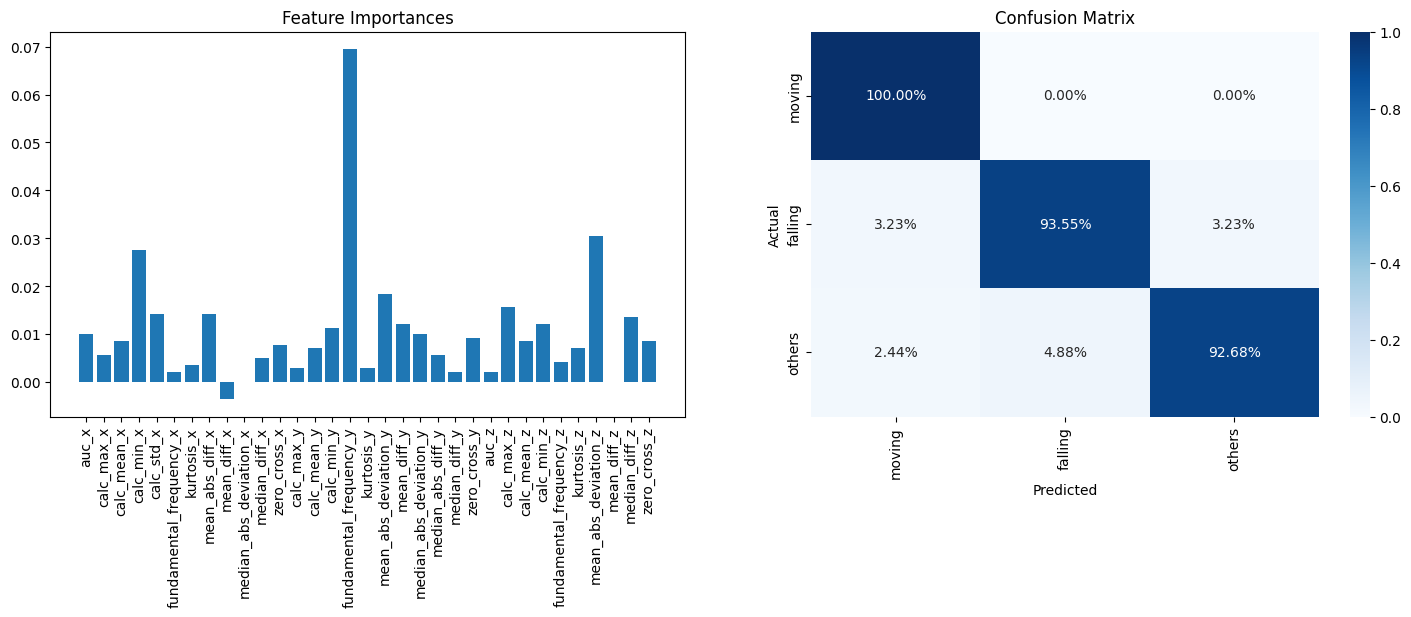

In [55]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

Using the feature importances we select the most important features and refit the model.

In [56]:
# Select the top k features
k = 6
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the SVC classifier using the top k features
best_kernel = best_params['kernel']
best_C = best_params['C']
best_gamma = best_params['gamma']

# Train the SVC with the best hyperparameters and kernel
svm_classifier = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, probability=True)
svm_classifier.fit(X_train_scaled[:, top_k_indices], Y_train)

# Predict test data
y_predict = svm_classifier.predict(X_test_scaled[:, top_k_indices])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(svm_classifier, X_train_scaled, y_predict,
                     Y_train, Y_test, activities, top_k_indices)


              precision    recall  f1-score   support

      moving       1.00      0.99      0.99        69
     falling       0.93      0.90      0.92        31
      others       0.91      0.95      0.93        41

    accuracy                           0.96       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141

Accuracy: 95.74468085106383%
Cross-validation scores: [0.98484848 0.98484848 0.93846154 0.90769231 0.98461538]
Mean cross-validation score: 0.96009324009324


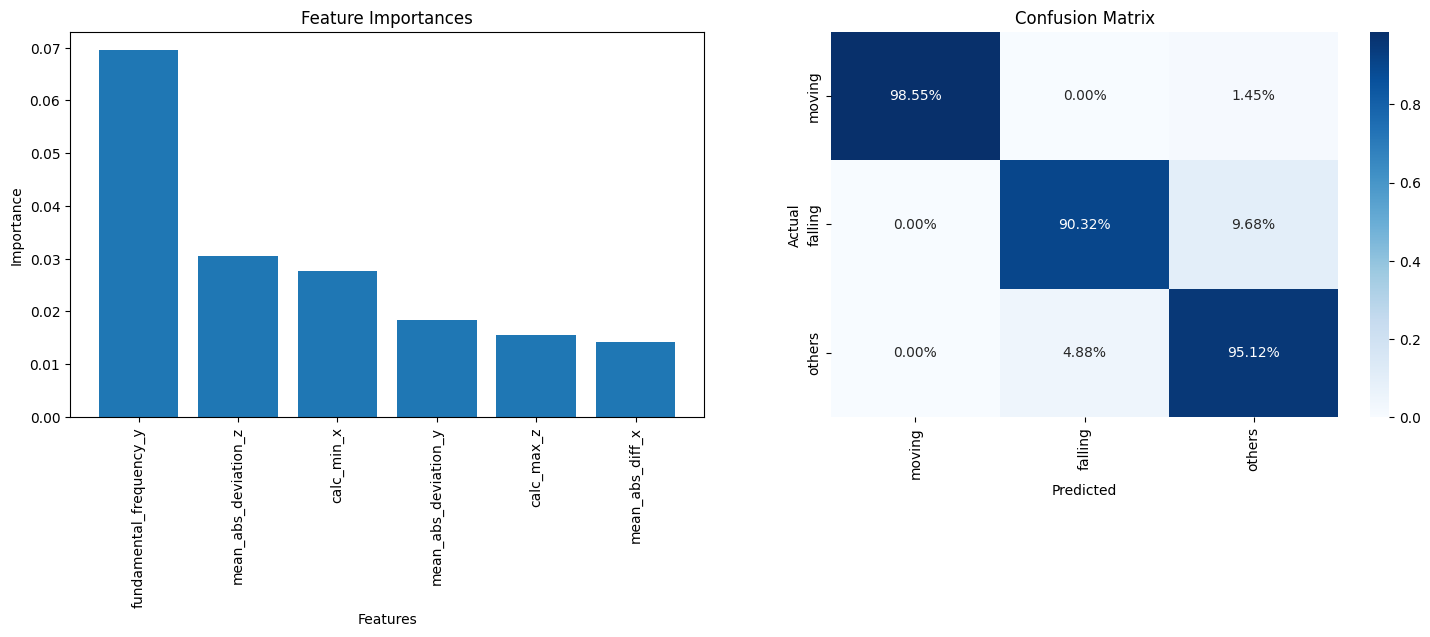

In [57]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


### 4.2.5 Gaussian Naive Bayes Classifier

The fifth and last model is a **Naive Bayes Classifier**.

In [58]:
# Train the Naive Bayes classifier
bayes_classifier = GaussianNB()

# Train The Classifier
bayes_classifier.fit(X_train, Y_train)

# Get the feature importances using permutation importance
result = permutation_importance(
    bayes_classifier, X_test, Y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Predict test data
y_predict = bayes_classifier.predict(X_test)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(bayes_classifier, X_train_scaled,
               y_predict, Y_train, Y_test, activities)


              precision    recall  f1-score   support

      moving       0.96      1.00      0.98        69
     falling       0.88      0.97      0.92        31
      others       1.00      0.85      0.92        41

    accuracy                           0.95       141
   macro avg       0.95      0.94      0.94       141
weighted avg       0.95      0.95      0.95       141

Accuracy: 95.0354609929078%
Cross-validation scores: [0.98484848 0.98484848 0.95384615 0.95384615 0.98461538]
Mean cross-validation score: 0.9724009324009325


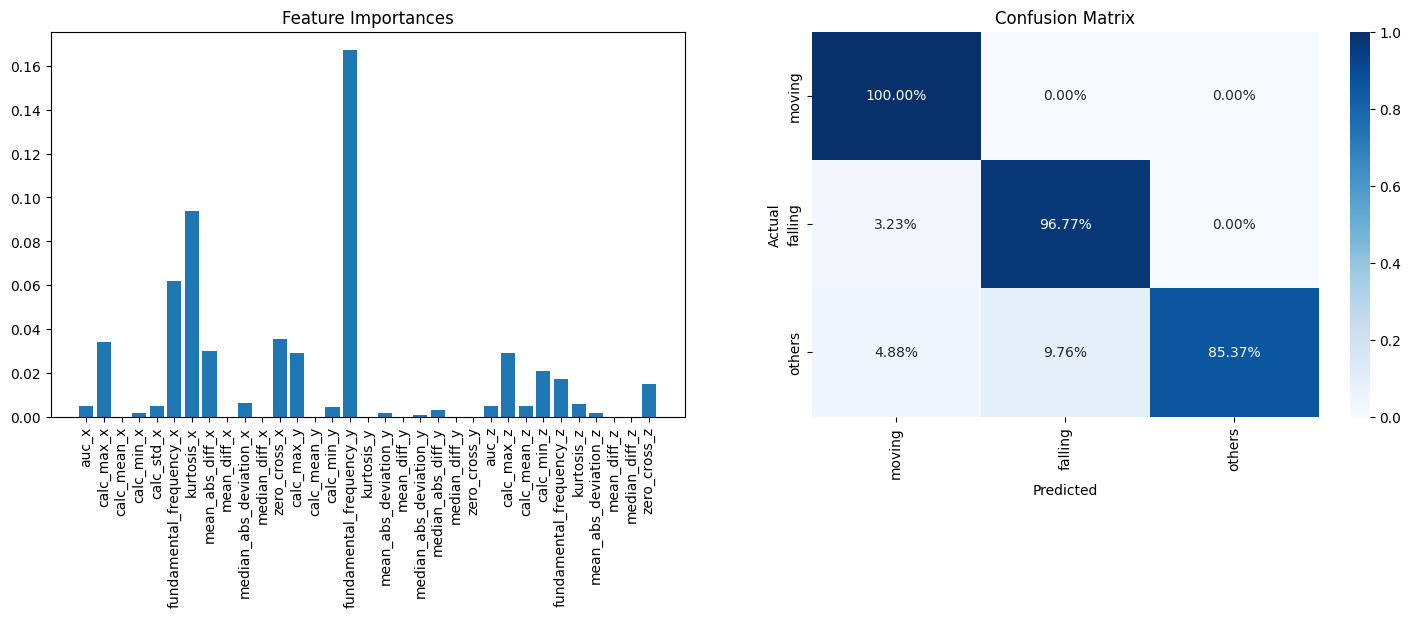

In [59]:
# Plot the feature importances and confusion matrix side by side
plot_importance_confusion(importances, X_train, y_predict, activities)


#### Feature importance selection

In [60]:
# Select the top k features
k = 7
top_k_indices = importances.argsort()[::-1][:k]
top_k_features = X_train.columns[top_k_indices]

# Train the Naive Bayes classifier using the top k features
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train[top_k_features], Y_train)

# Predict test data
y_predict = bayes_classifier.predict(X_test[top_k_features])

# Get the classification report and evaluate the model using cross-validation on the training set with top k features
evaluate_model_top_k(bayes_classifier, X_train_scaled,
                     y_predict, Y_train, Y_test, activities, top_k_indices)


              precision    recall  f1-score   support

      moving       1.00      1.00      1.00        69
     falling       0.88      0.90      0.89        31
      others       0.93      0.90      0.91        41

    accuracy                           0.95       141
   macro avg       0.93      0.94      0.93       141
weighted avg       0.95      0.95      0.95       141

Accuracy: 95.0354609929078%
Cross-validation scores: [0.96969697 0.96969697 0.92307692 0.93846154 0.98461538]
Mean cross-validation score: 0.9571095571095573


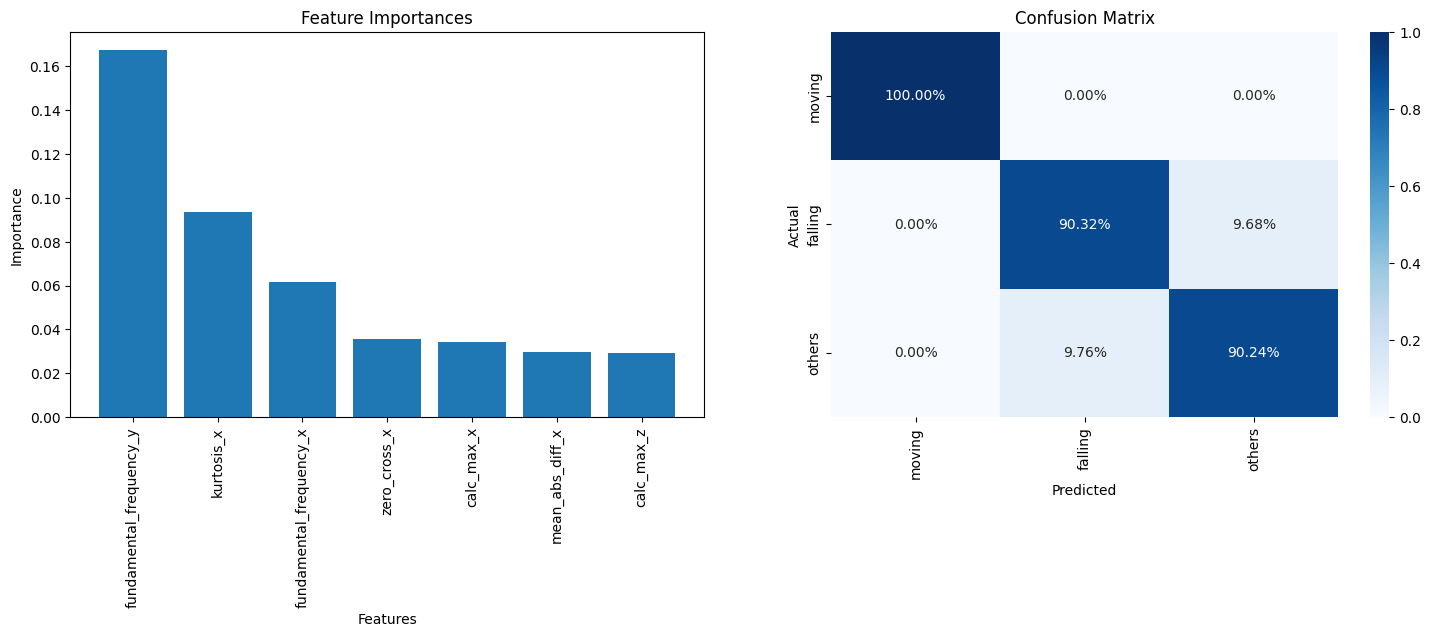

In [61]:
# Plot the feature importances and confusion matrix with top k features side by side
plot_importance_confusion_top_k(
    importances, X_train, y_predict, activities, top_k_features, top_k_indices, k)


# 4.3 Ensemble classifier

The most promising model up to now is the Random Forest classifier. With only 4 features it separates the classes exceptionally.
Also logistic regression is easily interpretable and has good performance.

As a last model, we try to put together an Ensemble Classifier, putting together the best performing models.

              precision    recall  f1-score   support

      moving       0.99      1.00      0.99        69
     falling       0.94      0.97      0.95        31
      others       1.00      0.95      0.97        41

    accuracy                           0.98       141
   macro avg       0.97      0.97      0.97       141
weighted avg       0.98      0.98      0.98       141

Accuracy: 97.87234042553192%
Cross-validation scores: [0.98484848 0.98484848 0.96923077 0.95384615 0.96923077]
Mean cross-validation score: 0.9724009324009325


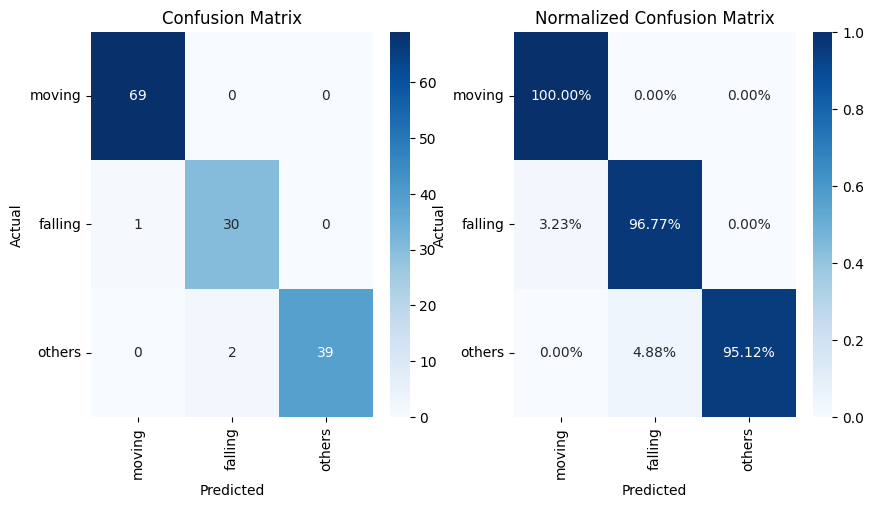

In [66]:
# Define the classifiers
svm = svm_classifier
rfc = random_forest_classifier
logreg = logistic_regression_classifier

# Define the ensemble model
ensemble_model = VotingClassifier(
    estimators=[('rfc', rfc), ('logreg', logreg)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, Y_train)

# Predict test data
y_predict = ensemble_model.predict(X_test_scaled)

# Get the classification report and evaluate the model using cross-validation on the training set
evaluate_model(ensemble_model, X_train_scaled,
               y_predict, Y_train, Y_test, activities)

conf_matrix = confusion_matrix(Y_test, y_predict)
# Plot the confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix')
axs[0].set_xticklabels(activities, rotation=90)
axs[0].set_yticklabels(activities, rotation=0)

cm = confusion_matrix(Y_test, y_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Normalized Confusion Matrix')
axs[1].set_xticklabels(activities, rotation=90)
axs[1].set_yticklabels(activities, rotation=0)

plt.show()


# 5. T-SNE visual

In [76]:
# Define the t-SNE model
tsne_model = TSNE(n_components=3, perplexity=30, random_state=42)

# Fit and transform the data to 3 dimensions
X_train_tsne = tsne_model.fit_transform(X_train_scaled)

# Define the interactive plot function


@interact(elev=(0, 90), azim=(-180, 180))
def plot_3d(elev=30, azim=30):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], c=Y_train)
    ax.set_title('t-SNE Clustering of X_train Data')
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_zlabel('t-SNE Feature 3')
    ax.view_init(elev=elev, azim=azim)
    plt.show()


interactive(children=(IntSlider(value=30, description='elev', max=90), IntSlider(value=30, description='azim',…